# ECG data analysis

Using the PTB-XL data, this notebook:
1. Loads the data
2. Explores the metadata,
3. Visualizes the signal data in interactive figures
4. Summarized a theory and literature review.
5. Extracts wave peaks from the 1D signals and visualizes these
6. explores the useage of a codebase for multilabel diagnostic classification, to expand on in future instance.

**Note:** on the first run, the second call will make the runtime crash to downgrade fastai to an older version.

In [1]:
# Import torchvision
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu117
0.15.1+cu117


In [2]:
## In this cell, set 'show_all_figs = False'
## if you want to save RAM for model training:
show_all_figs = True

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
## Import the libraries we will use in our initial exploration:
from pathlib import Path
import os
import requests
import zipfile
# from google.colab import drive
import pandas as pd
import numpy as np
# import plotly.graph_objects as go
# import plotly.express as px
import wfdb
import ast

## Allow "hot-reloading" of modules
%load_ext autoreload
%autoreload 2

## 1. Loading the data

In [5]:
data_filepath = 'D:/Test Jupyter/ECG-Classfier-main/data/numpy_data_lead2_cwt/'

Y_train = np.load(data_filepath + 'X_train.npy')
Z_train = np.load(data_filepath + 'y_train.npy', allow_pickle=True)
Y_test = np.load(data_filepath + 'X_test.npy')
Z_test = np.load(data_filepath + 'y_test.npy', allow_pickle=True)

In [6]:
print(Y_train.shape, Z_train.shape)
print(Y_test.shape,  Z_test.shape)

(17441, 100, 100, 3) (17441, 5)
(4396, 100, 100, 3) (4396, 5)


In [38]:
Y_train[0]

array([[[0.26851 , 0.009605, 0.335427],
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        ...,
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        [0.26851 , 0.009605, 0.335427]],

       [[0.267004, 0.004874, 0.329415],
        [0.269944, 0.014625, 0.341379],
        [0.269944, 0.014625, 0.341379],
        ...,
        [0.26851 , 0.009605, 0.335427],
        [0.26851 , 0.009605, 0.335427],
        [0.26851 , 0.009605, 0.335427]],

       [[0.280267, 0.073417, 0.397163],
        [0.271305, 0.019942, 0.347269],
        [0.277018, 0.050344, 0.375715],
        ...,
        [0.274952, 0.037752, 0.364543],
        [0.267004, 0.004874, 0.329415],
        [0.278791, 0.062145, 0.386592]],

       ...,

       [[0.19943 , 0.387607, 0.554642],
        [0.197636, 0.391528, 0.554969],
        [0.1941  , 0.399323, 0.555565],
        ...,
        [0.147607, 0.511733, 0.557049],
        [0.147607, 0.511733, 0.557049],
        [

In [7]:
from sklearn.preprocessing import StandardScaler
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape).astype('float32')
Y_test  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape).astype('float32')

In [8]:
# Convert your data to PyTorch tensors
# Convert NumPy arrays to PyTorch tensors with the appropriate data types
Y_train = torch.FloatTensor(Y_train)
# Converting DataFrame to a NumPy array and then to Pytorch tensor
# Z_train = Z_train.to_numpy()  # Convert Z_train DataFrame to a NumPy array
# Convert the NumPy array to a PyTorch tensor
Z_train = torch.FloatTensor(Z_train)

# Convert NumPy arrays to PyTorch tensors with the appropriate data types
Y_test = torch.FloatTensor(Y_test)
# Converting DataFrame to a NumPy array and then to Pytorch tensor
# Z_test = Z_test.to_numpy()  # Convert Z_test DataFrame to a NumPy array
# Convert the NumPy array to a PyTorch tensor
Z_test = torch.FloatTensor(Z_test)


In [9]:
Y_train.shape

torch.Size([17441, 100, 100, 3])

In [10]:
Y_test.shape

torch.Size([4396, 100, 100, 3])

In [11]:
Y_train=Y_train.permute(0,3,1,2)
# Y_train=Y_train.unsqueeze(dim = 0).permute(1,0,3,2) #torch.Size([17441, 1, 12, 500])
# Y_test=Y_test.unsqueeze(dim = 0).permute(1,0,3,2)
Y_test=Y_test.permute(0,3,1,2)

In [12]:
Y_train.shape

torch.Size([17441, 3, 100, 100])

In [13]:
Z_train.shape

torch.Size([17441, 5])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. Create Dataloaders

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, Y, Z):
        self.Y = torch.Tensor(Y)  # Input data
        self.Z = torch.Tensor(Z)  # Multilabel class labels

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.Y[idx], self.Z[idx]

# Create custom datasets and dataloaders
train_dataset = CustomDataset(Y_train, Z_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(Y_test, Z_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [16]:
for train_images, train_labels in train_loader:
    sample_image = train_images[0]    # Reshape them according to your needs.
    sample_label = train_labels[0]

# sample_image
sample_label

tensor([0., 1., 0., 0., 0.])

In [17]:
BATCH_SIZE = 32
# Let's check out what we have created
print(f"DataLoaders: {train_loader, test_loader}")
print(f"Length of the train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of the test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000019FB18A3910>, <torch.utils.data.dataloader.DataLoader object at 0x0000019FB18A1D20>)
Length of the train_loader: 546 batches of 32...
Length of the test_loader: 138 batches of 32...


In [18]:
# Check out what's inside training data loader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape
# test_features_batch, test_labels_batch = next(iter(test_loader))


(torch.Size([32, 3, 100, 100]), torch.Size([32, 5]))

## 3. Start creating models

In [24]:
# Create a CNN
class ECGModelV1(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website
  """
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,# or (3,3)
                  stride = 1,
                  padding = 1), #values we can set ourselves in our NNs are hyperparanteres
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)#learns compressed representation of the input
    )
    self.conv_block_2 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,# or (3,3)
                  stride = 1,
                  padding = 1), #values we can set ourselves in our NNs are hyperparanteres
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)#learns compressed representation of the input
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # nn.Linear(in_features=hidden_units*375,#There's a trick to calculating this
        nn.Linear(in_features=hidden_units*625,#There's a trick to calculating this
                  out_features = output_shape),
        nn.Sigmoid() # Sigmoid activation for multi-label classification
    )

  def forward(self,x):
    x= self.conv_block_1(x)
    # print(f"Output shape of conv block 1: {x.shape}")
    x= self.conv_block_2(x)
    # print(f"Output shape of conv block 2: {x.shape}")
    x= self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [25]:
torch.manual_seed(42)
model_1 = ECGModelV1(input_shape=3,#only back and white so 1 if colored =3
                              hidden_units=10,
                              output_shape=5).to(device)
model_1


ECGModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6250, out_features=5, bias=True)
    (2): Sigmoid()
  )
)

In [37]:
import torch
import torch.nn as nn

# Define your model architecture with Glorot initialization
class ECGModelV2(nn.Module):
    def __init__(self):
        super(ECGModelV2, self).__init__()

        # Convolutional layers
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(3750, 5, bias=True),
            nn.Sigmoid()
        )

        # Initialize the layers with Glorot initialization
        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

# Create an instance of your model
model_2 = ECGModelV2().to(device)

# Print the model to verify the architecture and initialization
print(model_2)


ECGModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3750, out_features=5, bias=True)
    (2): Sigmoid()
  )
)


In [36]:
import torch
import torch.nn as nn

class ResNetBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResNetBottleneckBlock, self).__init__()
        # Conv1x1 layer with batch normalization and ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Conv3x3 layer with batch normalization and ReLU
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Conv1x1 layer with batch normalization (no ReLU)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        
        # Shortcut connection if input and output channels differ
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * 4:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Add the shortcut connection
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CustomResNet, self).__init__()
        self.in_channels = 64  # Initial channels for the first ResNet block
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(input_channels, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # ResNet Blocks
        self.layer1 = self._make_layer(16, 3, stride=2)
        self.layer2 = self._make_layer(32, 4, stride=2)
        self.layer3 = self._make_layer(64, 3, stride=2)
        self.layer4 = self._make_layer(128, 3, stride=2)
        self.layer5 = self._make_layer(256, 2, stride=2)
        self.layer6 = self._make_layer(512, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc = nn.Linear(2048, output_channels)  # Adjust input_channels based on the final feature map size
        
    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResNetBottleneckBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * 4
        for _ in range(1, num_blocks):
            layers.append(ResNetBottleneckBlock(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

# Example usage:
input_channels = 1  # Input channels based on your data
output_channels = 5  # Output channels based on your requirement

model = CustomResNet(input_channels, output_channels).to(device)
print(model)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.48 GiB already allocated; 0 bytes free; 3.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
# Pass a random image through model
# rand_image_tensor = torch.randn(size=(1,12,500))
rand_image_tensor = torch.randn(size=(3,100,100))
rand_image_tensor.shape

torch.Size([3, 100, 100])

In [26]:
#Pass image through model
model_1(rand_image_tensor.unsqueeze(0).to(device))

tensor([[0.4885, 0.5141, 0.4901, 0.5406, 0.4741]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [24]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device = None):
  """Prints differnce between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time: .3f} seconds")
  return total_time

## 4. Define train and test steps

In [27]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.argmax(dim=1)).sum().item()
        total_samples += labels.size(0)

    train_accuracy = (correct_predictions / total_samples) * 100
    train_loss /= len(data_loader)

    # print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")

    return train_loss, train_accuracy


In [28]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, correct_predictions, total_samples = 0, 0, 0

    # Put the model in eval mode
    model.eval()

    # Turn off gradients and inference mode context manager
    with torch.no_grad():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y).item()

            # 3. Calculate accuracy (accumulatively)
            _, predicted = torch.max(test_pred, 1)
            correct_predictions += (predicted == y.argmax(dim=1)).sum().item()
            # correct_predictions += (predicted == y).sum().item()
            total_samples += y.size(0)

        # Calculate test loss and accuracy
        test_loss /= len(data_loader)
        test_accuracy = (correct_predictions / total_samples) * 100

        # print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%\n")

        return test_loss, test_accuracy


In [29]:
def evaluate_model(model, data_loader, loss_fn, device, threshold=0.5):
    model.eval()
    test_loss = 0.0
    # correct_predictions = 0
    correct_samples = 0
    total_samples = 0
    all_true_labels = []
    all_pred_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            predicted_labels = (outputs >= threshold).float()  # Apply threshold (e.g., 0.5)

            # Calculate correct predictions for the batch
            # batch_correct_predictions = (predicted_labels == labels).sum().item()
            batch_correct_samples = (predicted_labels == labels).all(dim=1).sum().item()


            # Count the total number of labels in the batch
            batch_total_samples = labels.sum().item()

            # correct_predictions += batch_correct_predictions
            correct_samples += batch_correct_samples
            # total_samples += inputs.size(0)
            total_samples += batch_total_samples

            # print("labels")
            # print(labels)
            # print("outputs")
            # print(outputs)
            # print("predicted_labels")
            # print(predicted_labels)
            # print("batch_correct_samples")
            # print(batch_correct_samples)
            # print("batch_total_samples")
            # print(batch_total_samples)
            # print("correct_samples")
            # print(correct_samples)
            # print("total_samples")
            # print(total_samples)

            all_true_labels.extend(labels.cpu().numpy())
            all_pred_scores.extend(predicted_labels.cpu().numpy())

        test_loss /= len(data_loader)
        # test_accuracy = (correct_predictions / total_samples) * 100
        test_accuracy = (correct_samples / total_samples) * 100

    return test_loss, test_accuracy, all_true_labels, all_pred_scores

In [30]:
def evaluate_model2(model, data_loader, loss_fn, device, threshold=0.5):
    model.eval()
    test_loss = 0.0
    correct_samples = 0
    total_samples = 0
    all_true_labels = []
    all_pred_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            predicted_labels = (outputs >= threshold).float()  # Apply threshold (e.g., 0.5)

            # Check if all labels for each sample are predicted correctly
            batch_correct_samples = (predicted_labels == labels).all(dim=1).sum().item()

            correct_samples += batch_correct_samples
            total_samples += inputs.size(0)

            all_true_labels.extend(labels.cpu().numpy())
            all_pred_scores.extend(predicted_labels.cpu().numpy())

        test_loss /= len(data_loader)
        test_accuracy = (correct_samples / total_samples) * 100

    return test_loss, test_accuracy, all_true_labels, all_pred_scores

## 5. Call model and print evaluation metrics

In [37]:
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr = 0.01)#optimize all bias and weight, i.e. everything in model_2.state_dict()

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:0
-----------
Train Loss: 0.4267 | Train Accuracy: 57.79%
Test Loss: 0.4405 | Test Accuracy: 40.04%
Epoch:1
-----------
Train Loss: 0.4118 | Train Accuracy: 58.99%
Test Loss: 0.4256 | Test Accuracy: 43.08%
Epoch:2
-----------
Train Loss: 0.4097 | Train Accuracy: 59.35%
Test Loss: 0.4350 | Test Accuracy: 44.18%
Epoch:3
-----------
Train Loss: 0.4042 | Train Accuracy: 59.68%
Test Loss: 0.4321 | Test Accuracy: 44.56%
Epoch:4
-----------
Train Loss: 0.3981 | Train Accuracy: 60.41%
Test Loss: 0.4345 | Test Accuracy: 44.95%
Epoch:5
-----------
Train Loss: 0.3928 | Train Accuracy: 60.58%
Test Loss: 0.4217 | Test Accuracy: 41.92%
Epoch:6
-----------
Train Loss: 0.3930 | Train Accuracy: 60.51%
Test Loss: 0.4524 | Test Accuracy: 42.42%
Epoch:7
-----------
Train Loss: 0.3900 | Train Accuracy: 60.99%
Test Loss: 0.4352 | Test Accuracy: 38.01%
Epoch:8
-----------
Train Loss: 0.3829 | Train Accuracy: 61.66%
Test Loss: 0.4303 | Test Accuracy: 41.56%
Epoch:9
-----------
Train Loss: 0.3791 | Train

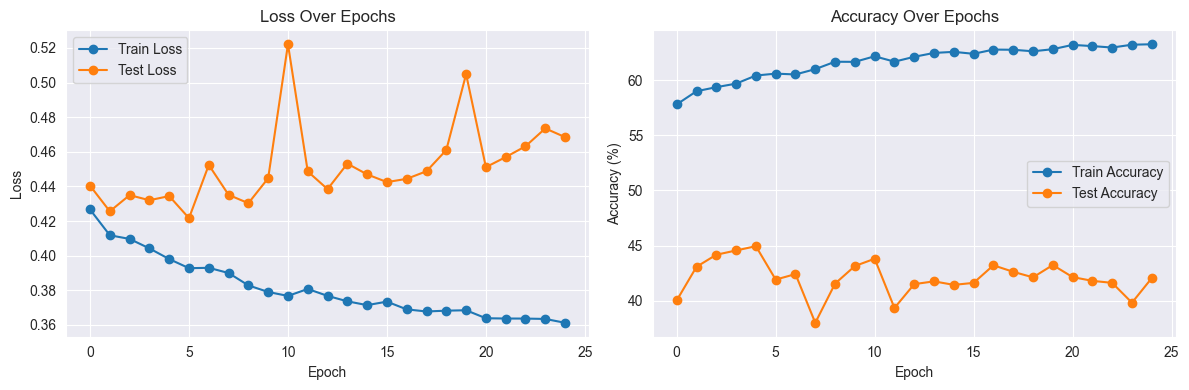

Precision: 0.6289
Recall: 0.4995
F1 Score: 0.5421
Classification Report:
              precision    recall  f1-score   support

        NORM       0.73      0.78      0.75     48025
          MI       0.56      0.28      0.38     27425
        STTC       0.61      0.45      0.52     26425
          CD       0.65      0.45      0.53     24875
         HYP       0.41      0.12      0.18     13350

   micro avg       0.66      0.50      0.57    140100
   macro avg       0.59      0.42      0.47    140100
weighted avg       0.63      0.50      0.54    140100
 samples avg       0.55      0.53      0.52    140100



c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, multilabel_confusion_matrix, classification_report, precision_recall_fscore_support
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

class_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize empty lists to store training and testing metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
all_true_labels = []
all_pred_scores = []

# Training and testing loop
epochs = 25
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----------")
    train_loss, train_accuracy = train_step(model=model_1,
                                            data_loader=train_loader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")

    test_loss, test_accuracy, true_labels, pred_scores = evaluate_model2(model=model_1,
                                                                       data_loader=test_loader,
                                                                       loss_fn=loss_fn,
                                                                       device=device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

    all_true_labels.extend(true_labels)
    all_pred_scores.extend(pred_scores)

# Plot training and testing metrics
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

# Convert predicted scores to binary predictions based on a threshold (e.g., 0.5)
threshold = 0.5
all_pred_labels = (np.array(all_pred_scores) >= threshold).astype(int)

# Calculate and print precision, recall, F1-score, confusion matrix
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_pred_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Print classification report
class_report = classification_report(all_true_labels, all_pred_labels, target_names=class_names)
print("Classification Report:")
print(class_report)
